# Custom Datasets and DataLoaders

In [3]:
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):

    def __init__(self, root, data, transformations=None):
        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/{data}/*/*"))]

        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None:
            im = self.transformations(im)

        return im, gt

def get_dls(root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4):

    # Create datasets
    tr_ds = CustomDataset(root=root, data="train", transformations=transformations)
    vl_ds = CustomDataset(root=root, data="valid", transformations=transformations)
    ts_ds = CustomDataset(root=root, data="test", transformations=transformations)

    # Print dataset sizes here
    print(f"Train dataset size: {len(tr_ds)}")
    print(f"Validation dataset size: {len(vl_ds)}")
    print(f"Test dataset size: {len(ts_ds)}")

    # Create dataloaders only if datasets are not empty
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns) if len(tr_ds) > 0 else None
    val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns) if len(vl_ds) > 0 else None
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns) if len(ts_ds) > 0 else None

    return tr_dl, val_dl, ts_dl, tr_ds.cls_names

# Example usage
root = "/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root=root, transformations=tfs, bs=32)

# Print dataloader sizes if they were created successfully
if tr_dl:
    print(f"Train DataLoader batches: {len(tr_dl)}")
if val_dl:
    print(f"Validation DataLoader batches: {len(val_dl)}")
if ts_dl:
    print(f"Test DataLoader batches: {len(ts_dl)}")

# Print class names
print(classes)


Train dataset size: 2756
Validation dataset size: 262
Test dataset size: 134
Train DataLoader batches: 87
Validation DataLoader batches: 9
Test DataLoader batches: 134
{'dry': 0, 'normal': 1, 'oily': 2}


# Data Visualization

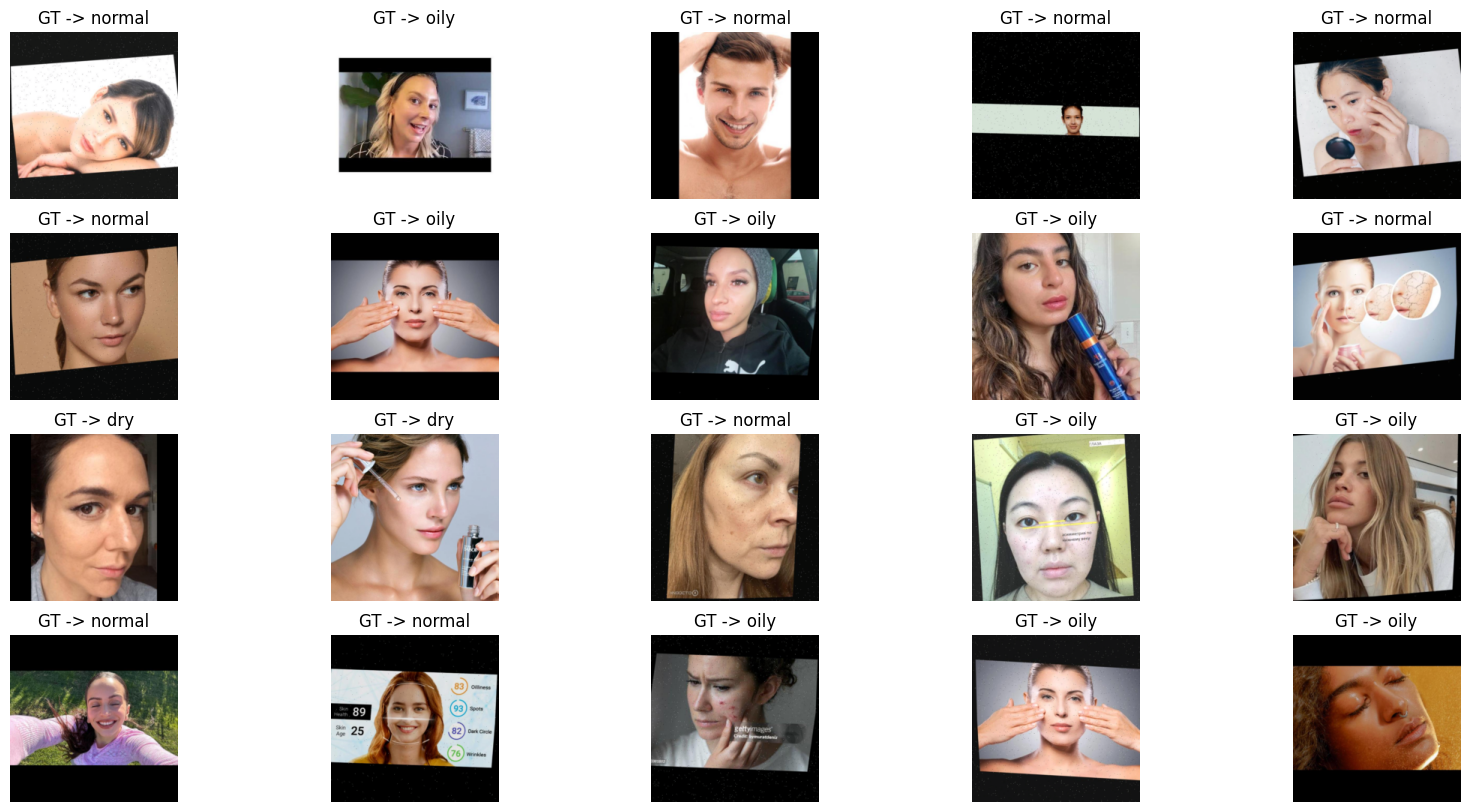

In [4]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

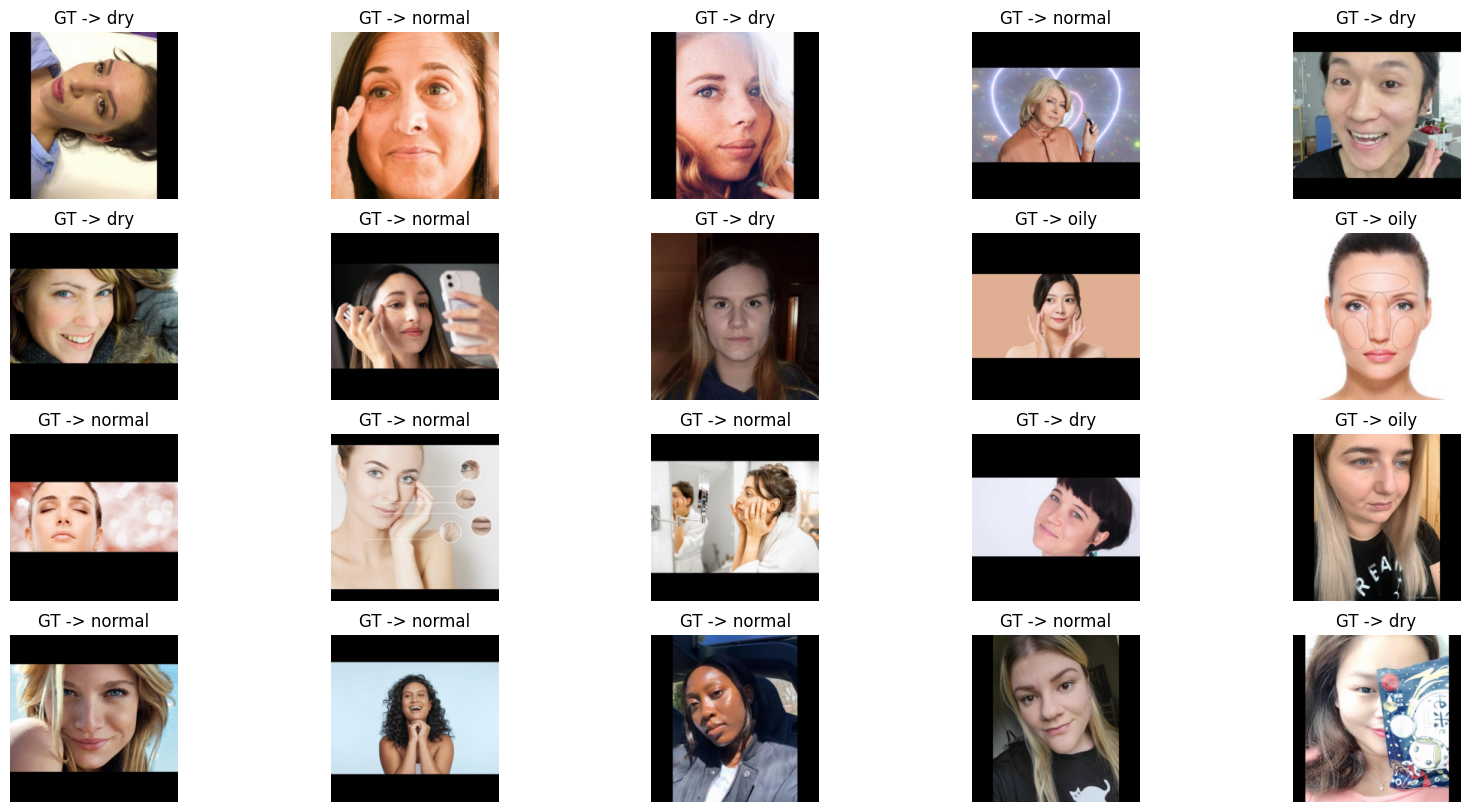

In [5]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

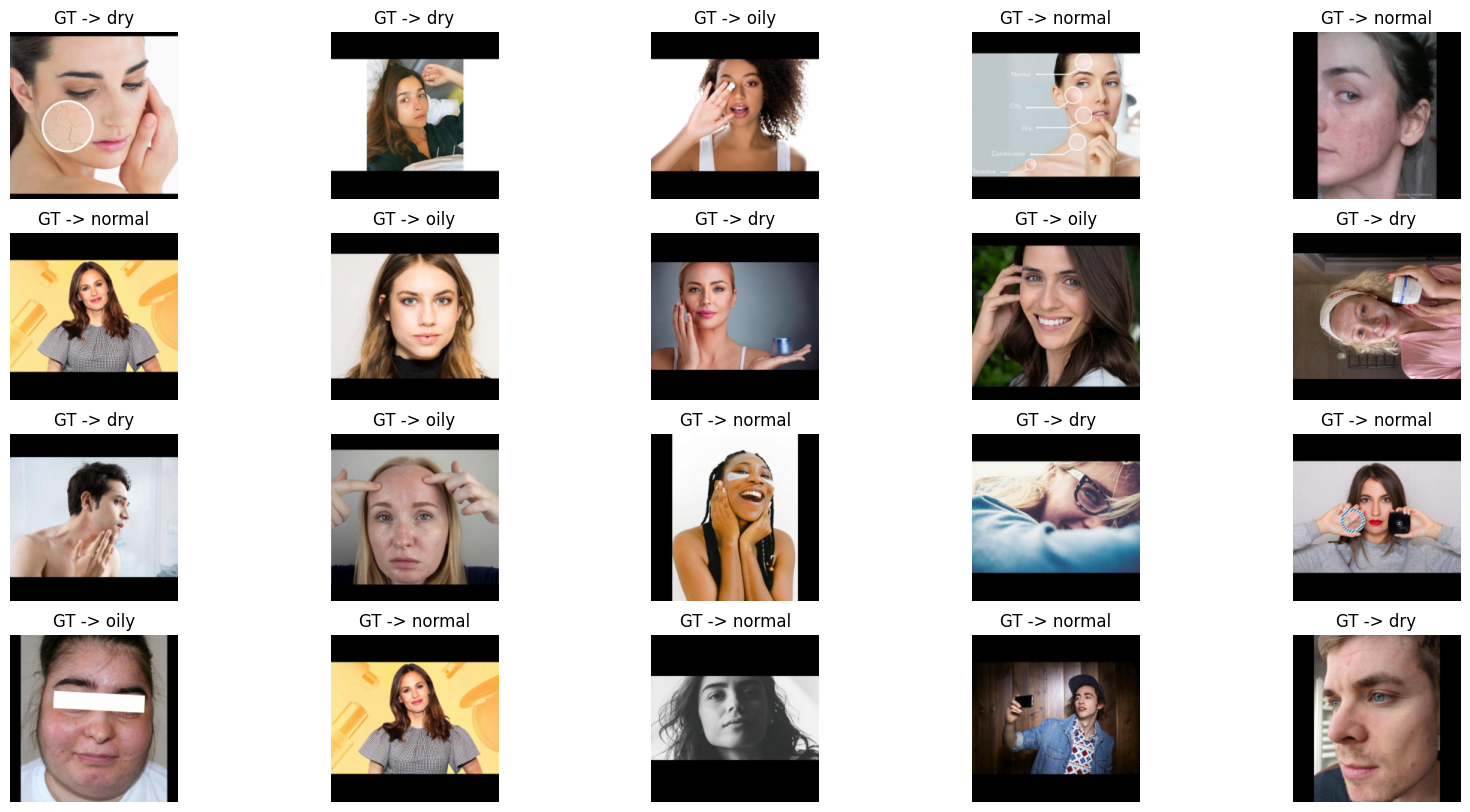

In [6]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

# Data Analysis

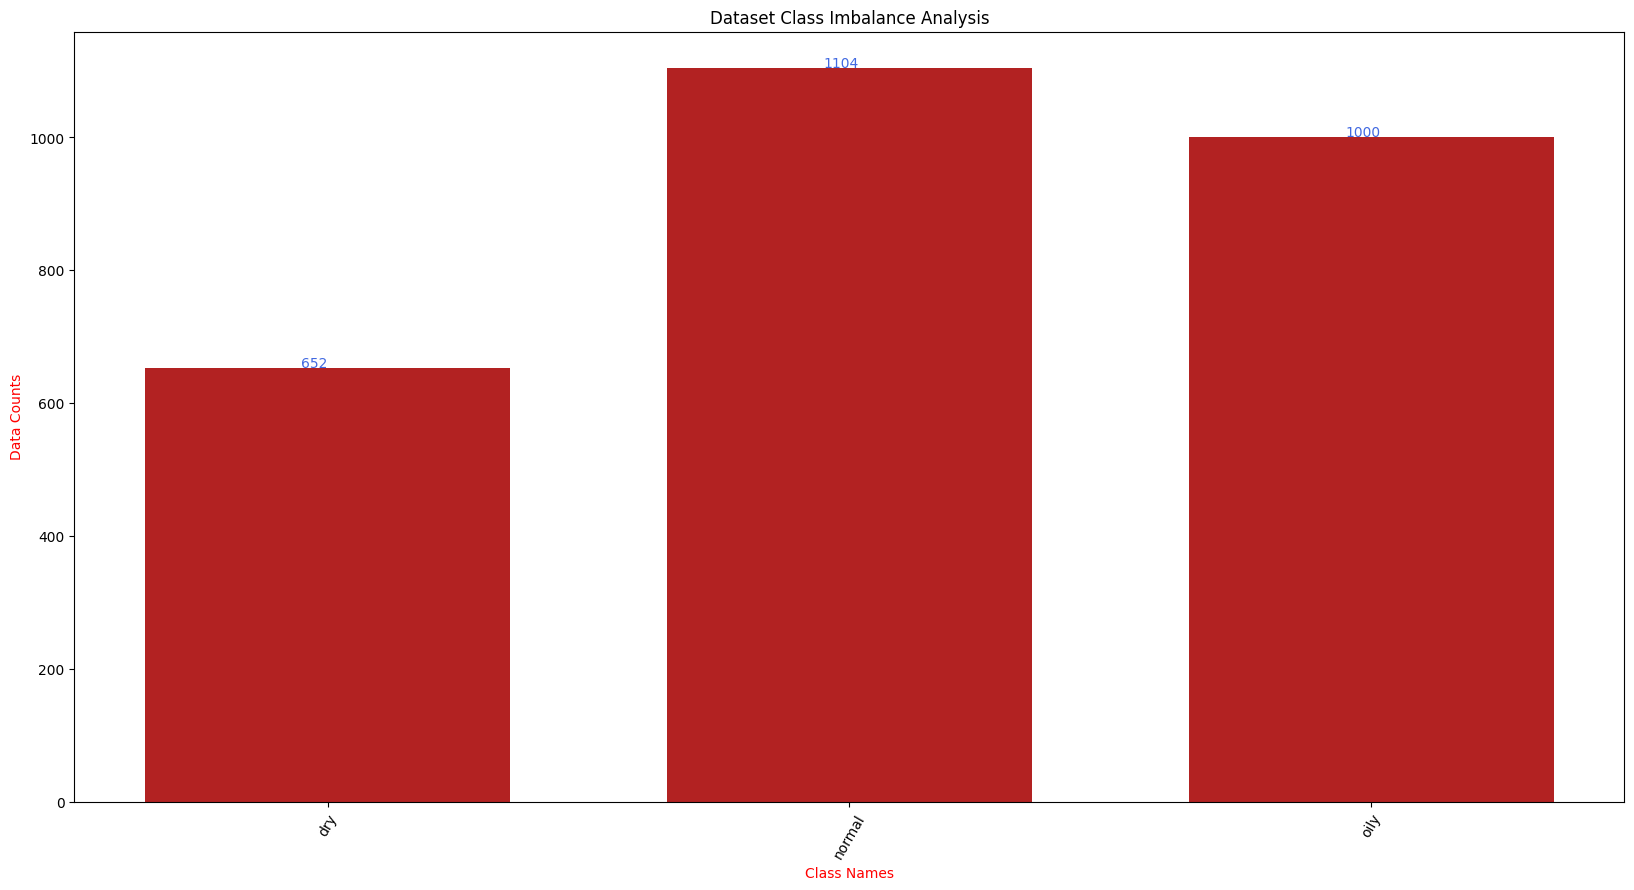

In [7]:
# Data Analysis

def data_analysis(root, data, transformations):

    ds = CustomDataset(root = root, data = data, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

data_analysis(root = root, data = "train", transformations = tfs)

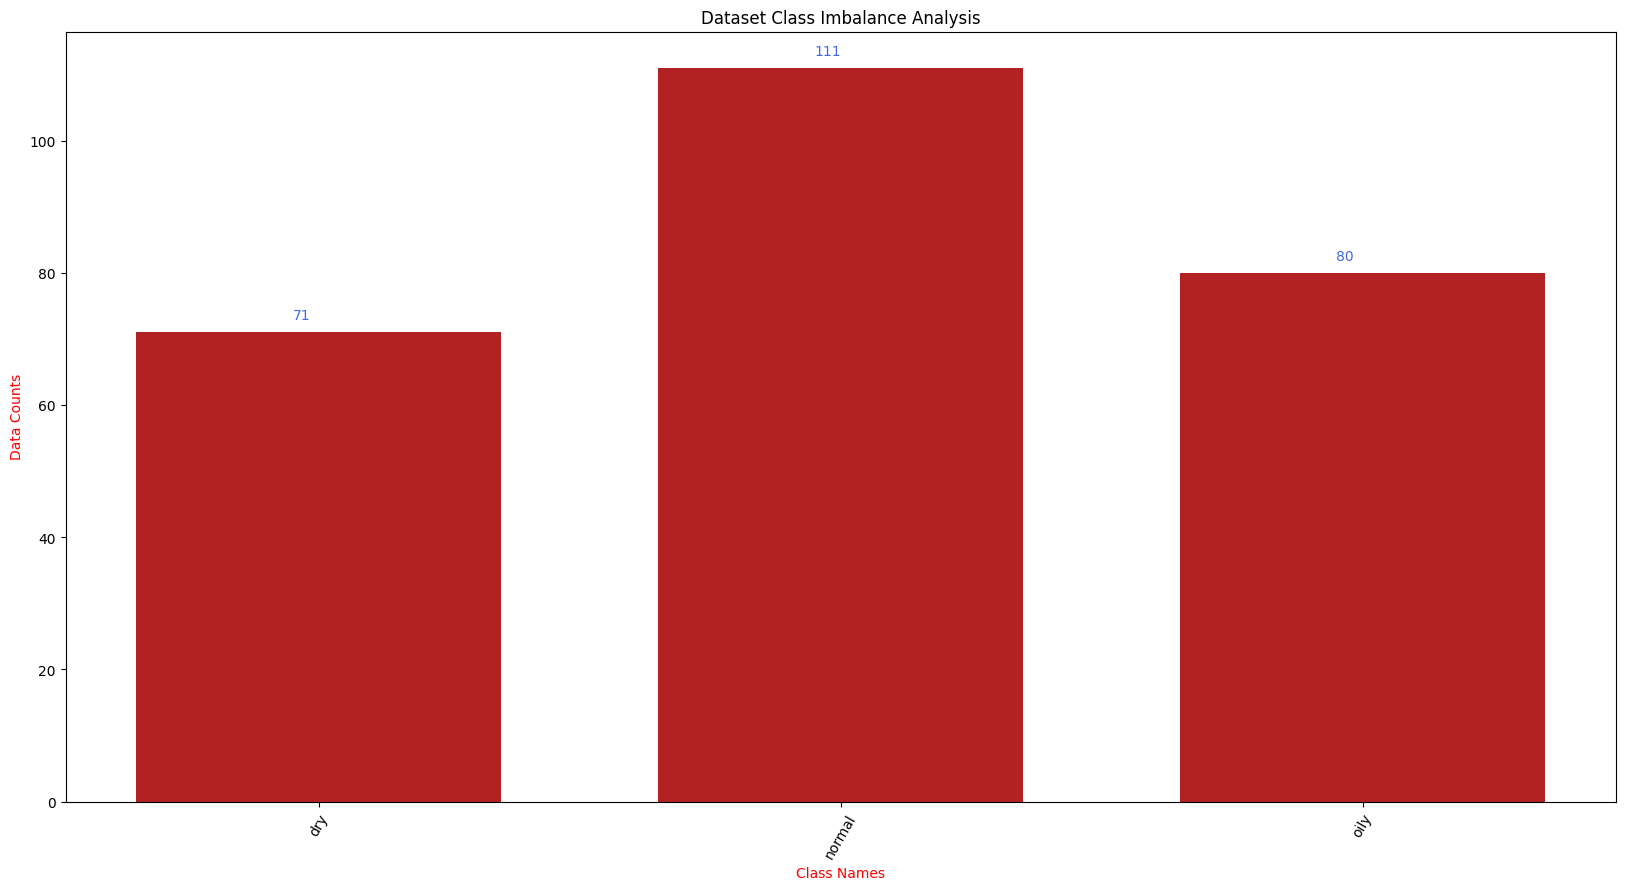

In [8]:
data_analysis(root = root, data = "valid", transformations = tfs)

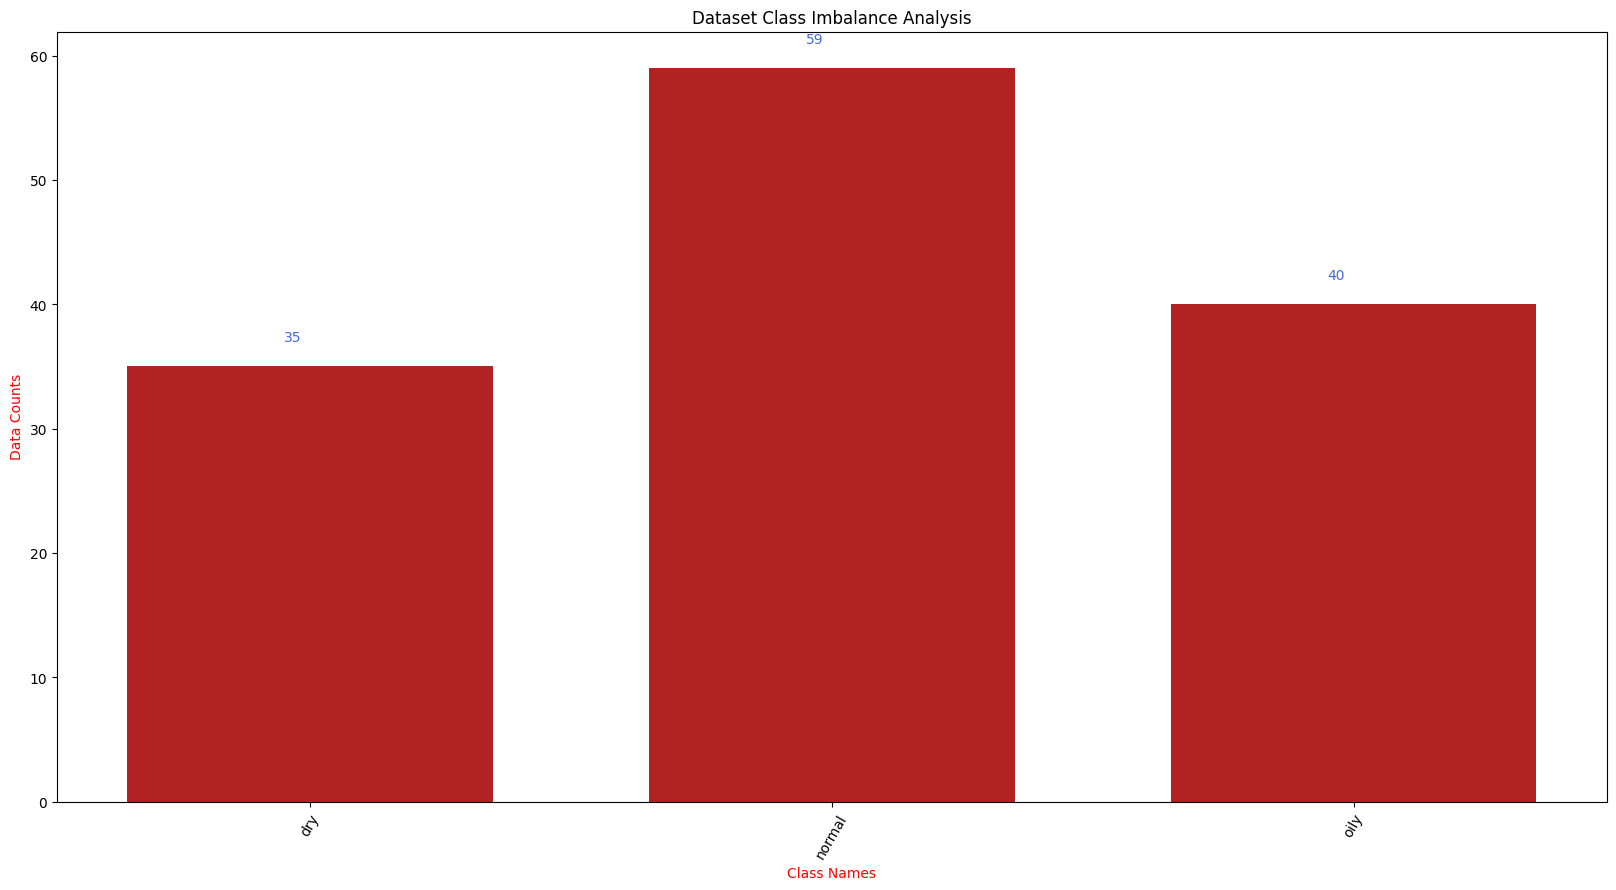

In [9]:
data_analysis(root = root, data = "test", transformations = tfs)

# AI Model Train and Validation

In [10]:
!pip install timm
!pip install torchmetrics

In [11]:
import timm, torchmetrics
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))

def train_setup(m): return m.to("cuda").eval(), 10, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "skin", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...


87it [00:19,  4.52it/s]

1-epoch train process is completed!
1-epoch train loss          -> 1.319
1-epoch train accuracy      -> 0.398
1-epoch train f1-score      -> 0.402


1-epoch validation process is completed!
1-epoch validation loss     -> 1.086
1-epoch validation accuracy -> 0.420
1-epoch validation f1-score -> 0.382


87it [00:17,  4.92it/s]

2-epoch train process is completed!
2-epoch train loss          -> 1.072
2-epoch train accuracy      -> 0.410
2-epoch train f1-score      -> 0.406


2-epoch validation process is completed!
2-epoch validation loss     -> 1.080
2-epoch validation accuracy -> 0.382
2-epoch validation f1-score -> 0.362


87it [00:17,  4.85it/s]

3-epoch train process is completed!
3-epoch train loss          -> 1.066
3-epoch train accuracy      -> 0.416
3-epoch train f1-score      -> 0.417


3-epoch validation process is completed!
3-epoch validation loss     -> 1.067
3-epoch validation accuracy -> 0.321
3-epoch validation f1-score -> 0.352


87it [00:18,  4.81it/s]

4-epoch train process is completed!
4-epoch train loss          -> 1.013
4-epoch train accuracy      -> 0.475
4-epoch train f1-score      -> 0.476


4-epoch validation process is completed!
4-epoch validation loss     -> 1.314
4-epoch validation accuracy -> 0.405
4-epoch validation f1-score -> 0.383
Loss value did not decrease for 1 epochs


87it [00:18,  4.77it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.986
5-epoch train accuracy      -> 0.492
5-epoch train f1-score      -> 0.492


5-epoch validation process is completed!
5-epoch validation loss     -> 1.220
5-epoch validation accuracy -> 0.420
5-epoch validation f1-score -> 0.382
Loss value did not decrease for 2 epochs


87it [00:18,  4.71it/s]


6-epoch train process is completed!
6-epoch train loss          -> 0.892
6-epoch train accuracy      -> 0.569
6-epoch train f1-score      -> 0.569
6-epoch validation process is completed!
6-epoch validation loss     -> 1.258
6-epoch validation accuracy -> 0.344
6-epoch validation f1-score -> 0.388
Loss value did not decrease for 3 epochs


87it [00:18,  4.65it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.755
7-epoch train accuracy      -> 0.672
7-epoch train f1-score      -> 0.670


7-epoch validation process is completed!
7-epoch validation loss     -> 1.774
7-epoch validation accuracy -> 0.347
7-epoch validation f1-score -> 0.391
Loss value did not decrease for 4 epochs


87it [00:18,  4.59it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.605
8-epoch train accuracy      -> 0.750
8-epoch train f1-score      -> 0.750


8-epoch validation process is completed!
8-epoch validation loss     -> 2.380
8-epoch validation accuracy -> 0.389
8-epoch validation f1-score -> 0.399
Loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.


# Learning Curves

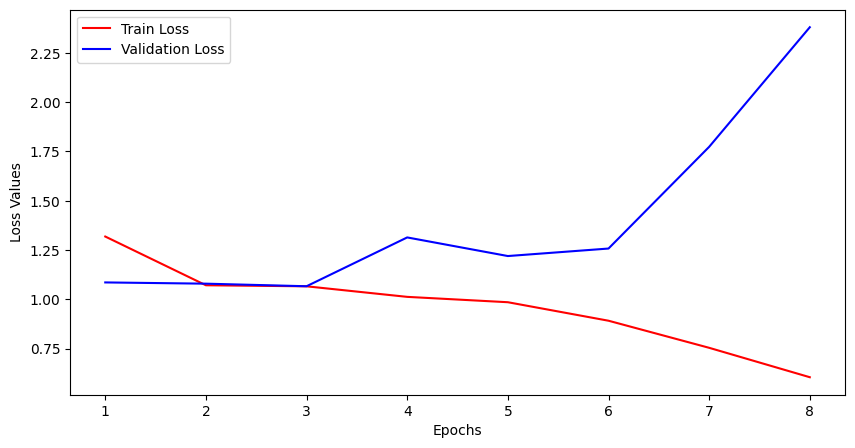

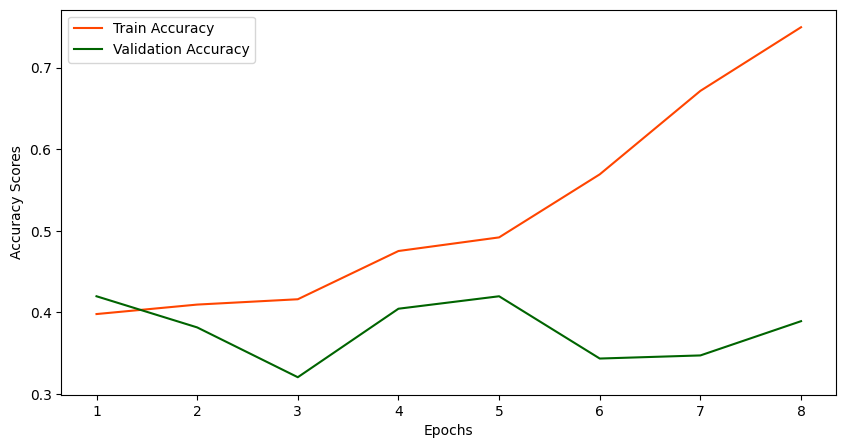

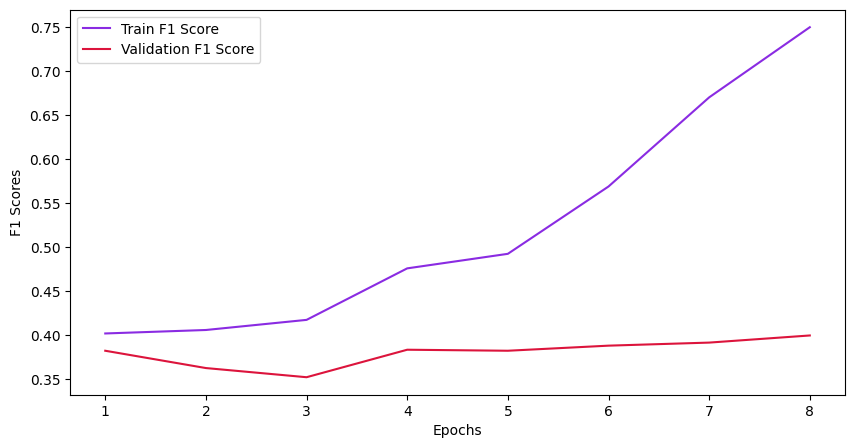

In [12]:
class PlotLearningCurves:

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):

        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):

        plt.plot(array_1, label = label_1, c = color_1); plt.plot(array_2, label = label_2, c = color_2)

    def create_figure(self): plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):

        plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend(); plt.show()

    def visualize(self):

        # Figure 1
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "red", color_2 = "blue"); self.decorate(ylabel = "Loss Values")

        # Figure 2
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "orangered", color_2 = "darkgreen")
        self.decorate(ylabel = "Accuracy Scores")

        # Figure 3
        self.create_figure()
        self.plot(array_1 = [tr_f1.cpu() for tr_f1 in self.tr_f1s], array_2 = [vl_f1.cpu() for vl_f1 in self.val_f1s], label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "blueviolet", color_2 = "crimson"); self.decorate(ylabel = "F1 Scores")

PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()


# Inference and AI Model Performance Analysis with GradCAM

134it [00:02, 46.74it/s]


Accuracy of the model on the test data -> 0.396


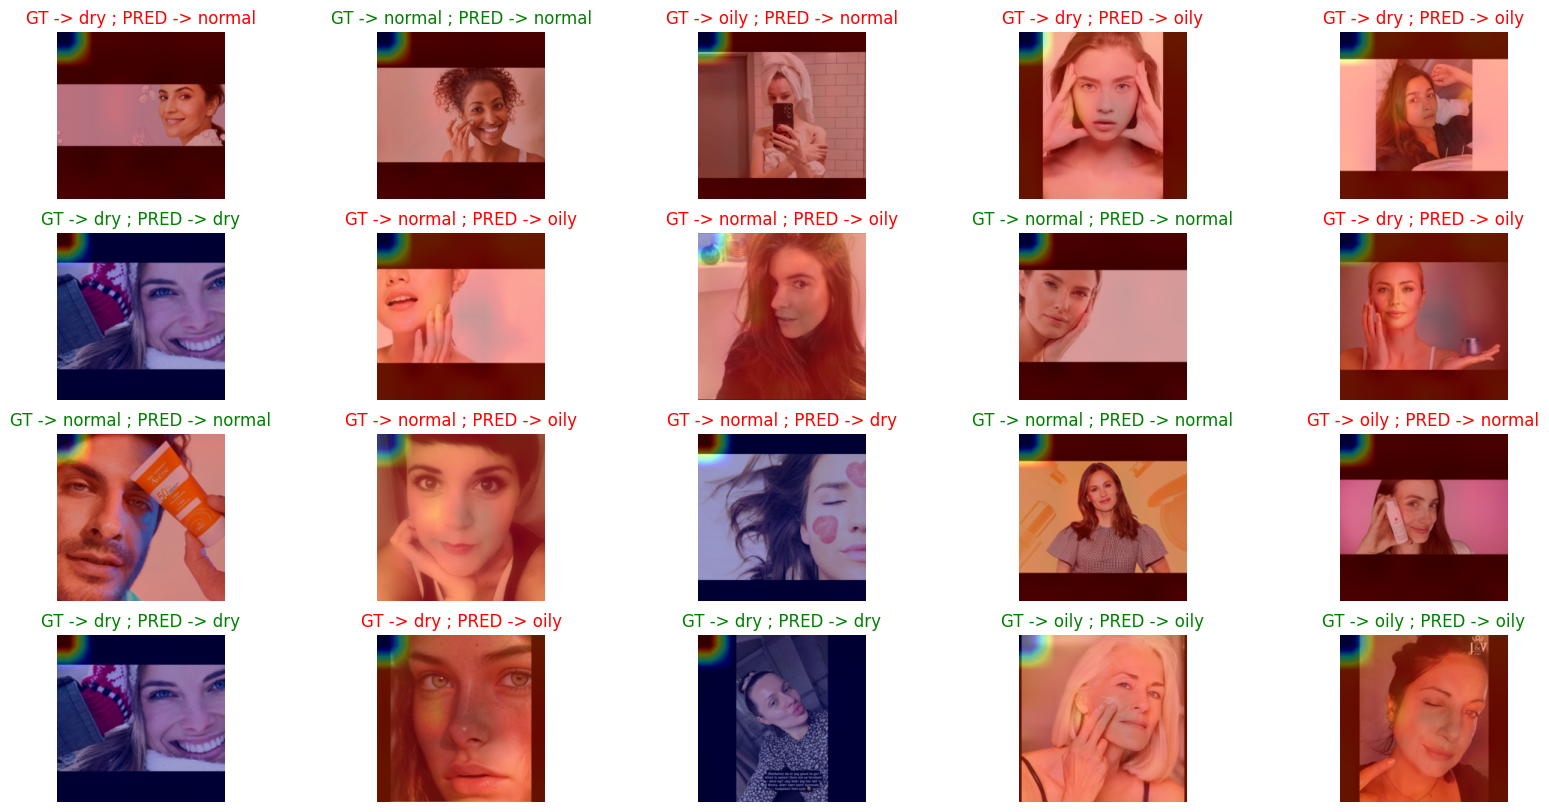

In [13]:
import cv2
class SaveFeatures():

    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):

    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)

    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):

    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())

    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]

    for idx, indeks in enumerate(indekslar):

        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")

        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth", weights_only=True))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)

# ResNet50 fine-tuning 85%

In [14]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [15]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [16]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

Creating dataset

In [17]:
train_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train")
val_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid")
test_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test")
train_df = pd.concat([train_df, val_df, test_df])

Defining training parameters

In [18]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))

        return img, label

train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)


train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

Downloading ResNet50

In [19]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s] 


cuda


Training tools

In [20]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Training

In [21]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    total = 0
    acc = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    total = 0
    acc = 0

    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

Epochs 1 train loss 0.04547015838517125 acc 0.45180483934946447 val loss 0.042987246740432014 acc 0.44761904761904764
Epochs 2 train loss 0.023586110161297476 acc 0.6767155890519635 val loss 0.031545148766230026 acc 0.6190476190476191
Epochs 3 train loss 0.014984720061100555 acc 0.8183260610868703 val loss 0.028166991756075906 acc 0.6095238095238096
Epochs 4 train loss 0.009776967718387491 acc 0.882189607298691 val loss 0.024805807783490137 acc 0.7301587301587301
Epochs 5 train loss 0.007496052786252746 acc 0.9170963903213011 val loss 0.02926706832552713 acc 0.7047619047619048
Epochs 6 train loss 0.005001904408919201 acc 0.9480364934549782 val loss 0.02949868913680788 acc 0.6730158730158731
Epochs 7 train loss 0.0034210319977692554 acc 0.9674732249107497 val loss 0.028768207345690047 acc 0.7428571428571429
Epochs 8 train loss 0.0028390737741044807 acc 0.9662832209440698 val loss 0.031224019754500617 acc 0.7301587301587301
Epochs 9 train loss 0.0027703521632837283 acc 0.9714399047996827

Model's performance log

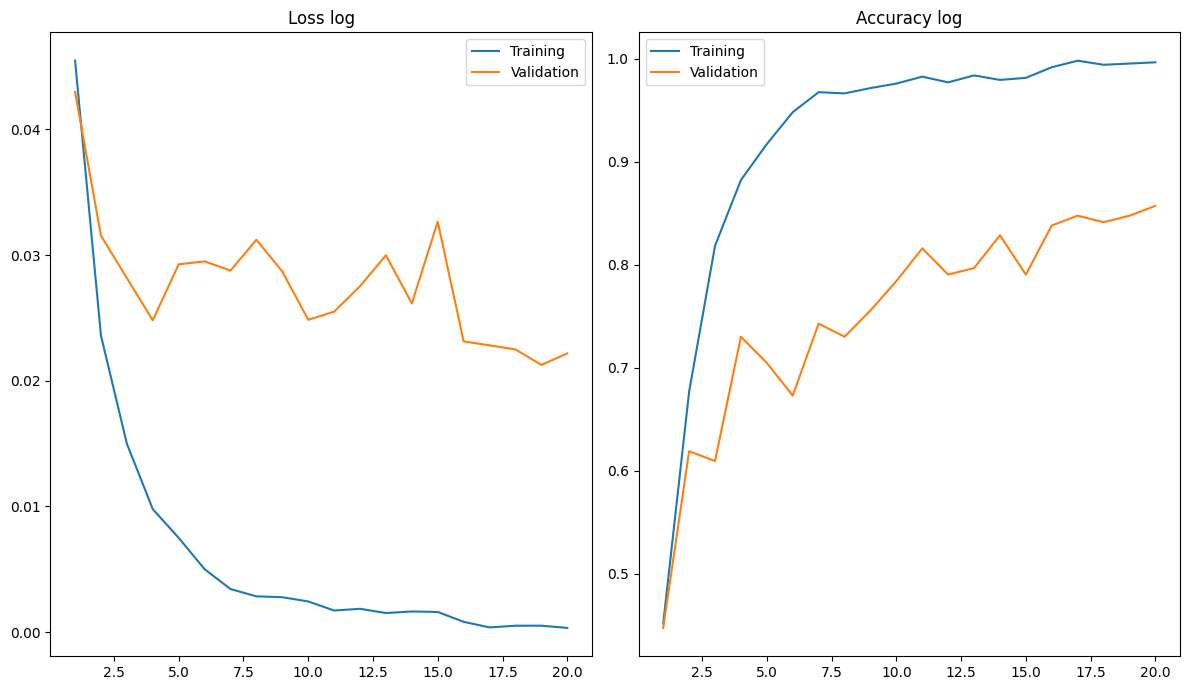

In [22]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

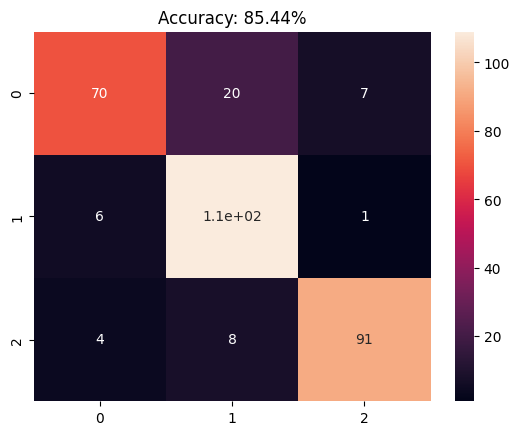

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        97
           1       0.80      0.94      0.86       116
           2       0.92      0.88      0.90       103

    accuracy                           0.85       316
   macro avg       0.86      0.85      0.85       316
weighted avg       0.86      0.85      0.85       316



In [23]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()

        out = best_model(img)

        return out.argmax(1).item()

pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()
print(report)


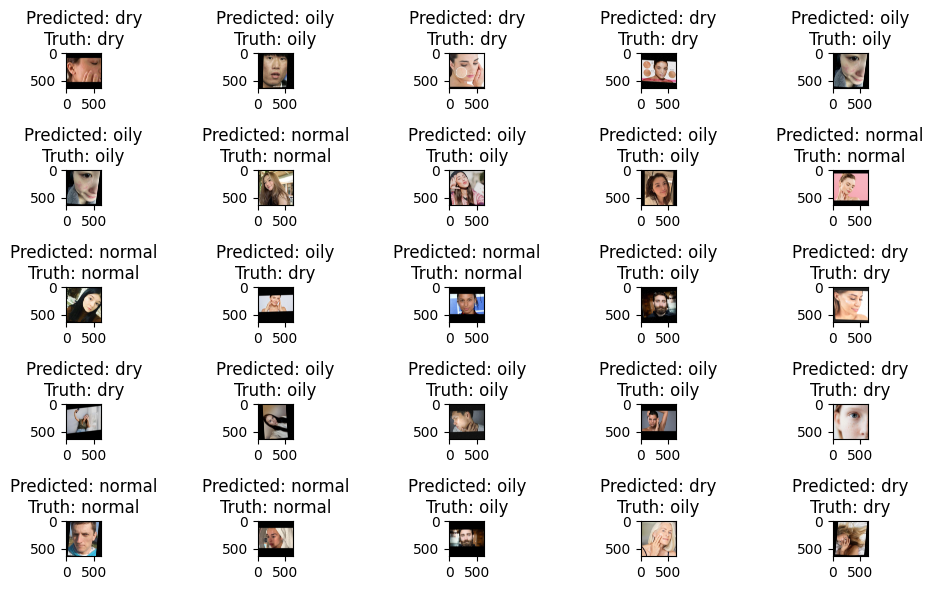

In [24]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()


# Image Detection

In [25]:
#!pip install transformers

In [26]:
# Install necessary Python packages using pip

# Use the 'pip' command to install packages
# The '-q' flag stands for 'quiet,' which means it will suppress most output, making the installation process less verbose
# We're installing the following packages:
# - 'evaluate': This package is likely used for evaluation purposes, but the specific functionality is not clear from this line alone
# - 'transformers': This package is commonly used for natural language processing tasks, such as working with pre-trained language models like BERT or GPT
# - 'datasets': This package provides easy access to various datasets commonly used in machine learning and natural language processing tasks

# Note: Before running this code, make sure you have Python and pip installed on your system.
# Also, ensure you have an internet connection since pip will download and install these packages from PyPI (Python Package Index).
!pip install -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null



In [27]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler # import RandomUnderSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [28]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [29]:
# use https://huggingface.co/docs/datasets/image_load for reference

# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os
# Initialize empty lists to store file names and labels
file_names = []
labels = []
# Iterate through all image files in the specified directory
for file in tqdm(sorted((Path('/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types').glob('*/*/*.*')))):
    if str(file).endswith('pg') or str(file).endswith('png'):
        file_names.append(str(file))  # Add the file path to the list
        label = str(file).split('/')[-2]  # Extract the label from the file path
        labels.append(label)  # Add the label to the list

# Print the total number of file names and labels
print(len(file_names), len(labels), len(set(labels)))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

100%|██████████| 3152/3152 [00:00<00:00, 175061.19it/s]

3152 3152 3


In [30]:
df['label'].unique()
df['label'].value_counts().head(50)
# # random undersampling of a majority class
# rus = RandomUnderSampler(random_state=83, sampling_strategy='majority')
# y = df[['label']]
# df = df.drop(['label'], axis=1)
# df, y_resampled = rus.fit_resample(df, y)
# del y
# df['label'] = y_resampled
# del y_resampled
# random oversampling of all minority classes
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

print(df.shape)

df['label'].value_counts().head(50)


(3822, 2)


label
dry       1274
normal    1274
oily      1274
Name: count, dtype: int64

Create dataset

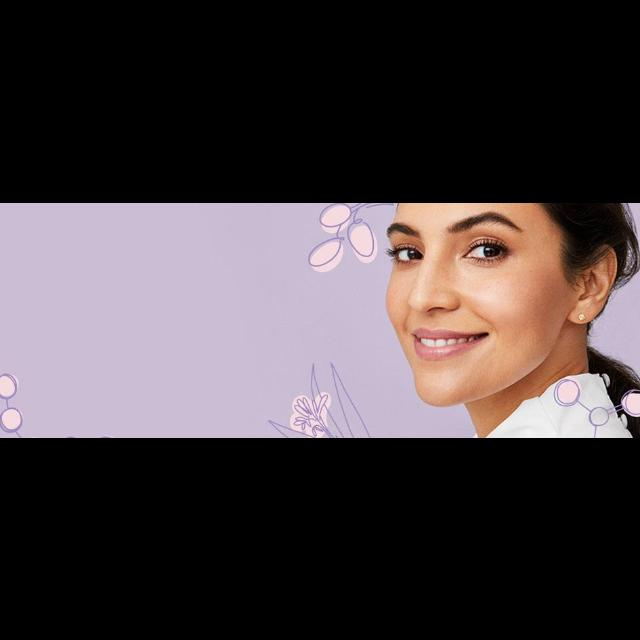

In [31]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())
dataset[0]["image"]

In [32]:
# Extracting a subset of elements from the 'labels' list using slicing.
# The slicing syntax [:5] selects elements from the beginning up to (but not including) the 5th element.
# This will give us the first 5 elements of the 'labels' list.
# The result will be a new list containing these elements.
labels_subset = list(df['label'])[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

['dry', 'dry', 'dry', 'dry', 'dry']


In [33]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = sorted(list(set(df['label'])))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'dry', 1: 'normal', 2: 'oily'} 

Mapping of Labels to IDs: {'dry': 0, 'normal': 1, 'oily': 2}


In [34]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/3822 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3822 [00:00<?, ? examples/s]

In [35]:
# Define the pre-trained ViT model string
model_str = "dima806/skin_types_image_detection" # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

Size:  224


In [36]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

# Load, train, and evaluate model

In [37]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])

    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

85.800963


In [38]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [39]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "skin_types_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 5

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,

    # Specify the directory where training logs will be stored.
    logging_dir='./logs',

    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",

    # Set the learning rate for the optimizer.
    learning_rate=5e-7,

    # Define the batch size for training on each device.
    per_device_train_batch_size=64,

    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=32,

    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,

    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,

    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,

    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,

    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',

    # Load the best model at the end of training.
    load_best_model_at_end=True,

    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,

    # Specify that training progress should not be reported.
    report_to="none"
)
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)
# Evaluate the pre-training model's performance on a test dataset.
# This function calculates various metrics such as accuracy, loss, etc.,
# to assess how well the model is performing on unseen data.

trainer.evaluate()

{'eval_loss': 0.9221020340919495,
 'eval_accuracy': 0.6559843034663179,
 'eval_runtime': 21.9518,
 'eval_samples_per_second': 69.653,
 'eval_steps_per_second': 1.093}

In [40]:
# Start training the model using the trainer object.
trainer.train()

# Evaluate the post-training model's performance on the validation or test dataset.
# This function computes various evaluation metrics like accuracy, loss, etc.
# and provides insights into how well the model is performing.

trainer.evaluate()

{'eval_loss': 0.919834554195404,
 'eval_accuracy': 0.658600392413342,
 'eval_runtime': 19.8777,
 'eval_samples_per_second': 76.92,
 'eval_steps_per_second': 1.207,
 'epoch': 5.0}

In [41]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.919834554195404, 'test_accuracy': 0.658600392413342, 'test_runtime': 19.8318, 'test_samples_per_second': 77.098, 'test_steps_per_second': 1.21}


Accuracy: 0.6586
F1 Score: 0.6586


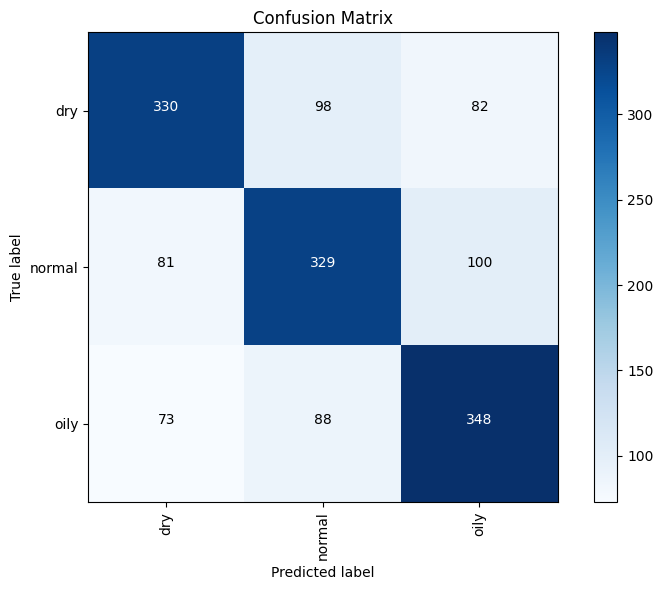


Classification report:

              precision    recall  f1-score   support

         dry     0.6818    0.6471    0.6640       510
      normal     0.6388    0.6451    0.6420       510
        oily     0.6566    0.6837    0.6699       509

    accuracy                         0.6586      1529
   macro avg     0.6591    0.6586    0.6586      1529
weighted avg     0.6591    0.6586    0.6586      1529



In [42]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """

    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
try:
    print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))
except:
    pass

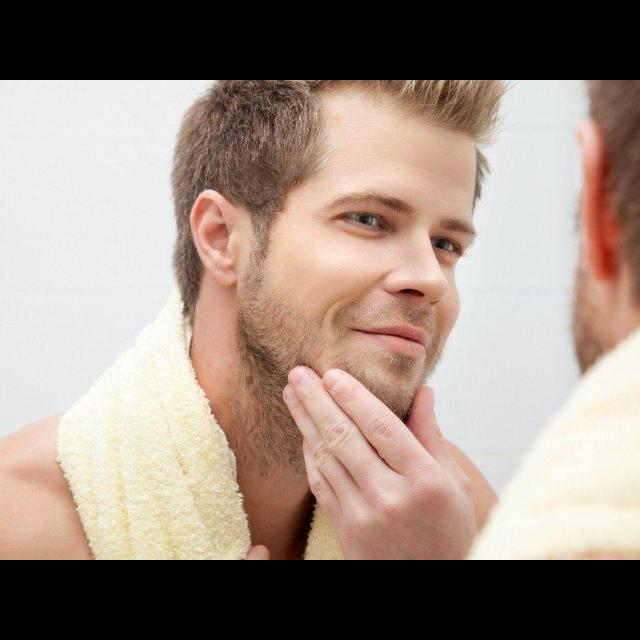

In [43]:
# Save the trained model: This line of code is responsible for saving the model
# that has been trained using the trainer object. It will serialize the model
# and its associated weights, making it possible to reload and use the model
# in the future without the need to retrain it.
trainer.save_model()
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline

# Create a pipeline for image classification tasks.
# You need to specify the 'model_name' and the 'device' to use for inference.
# - 'model_name': The name of the pre-trained model to be used for image classification.
# - 'device': Specifies the device to use for running the model (0 for GPU, -1 for CPU).
pipe = pipeline('image-classification', model=model_name, device=0)
# Accessing an image from the 'test_data' dataset using index 1.
image = test_data[1]["image"]

# Displaying the 'image' variable.
image

In [44]:
# Apply the 'pipe' function to process the 'image' variable.
pipe(image)

[{'label': 'dry', 'score': 0.5896005630493164},
 {'label': 'oily', 'score': 0.48794665932655334},
 {'label': 'normal', 'score': 0.4609951078891754}]

In [45]:
# This line of code accesses the "label" attribute of a specific element in the test_data list.
# It's used to retrieve the actual label associated with a test data point.
id2label[test_data[1]["label"]]

'oily'

# TESTING

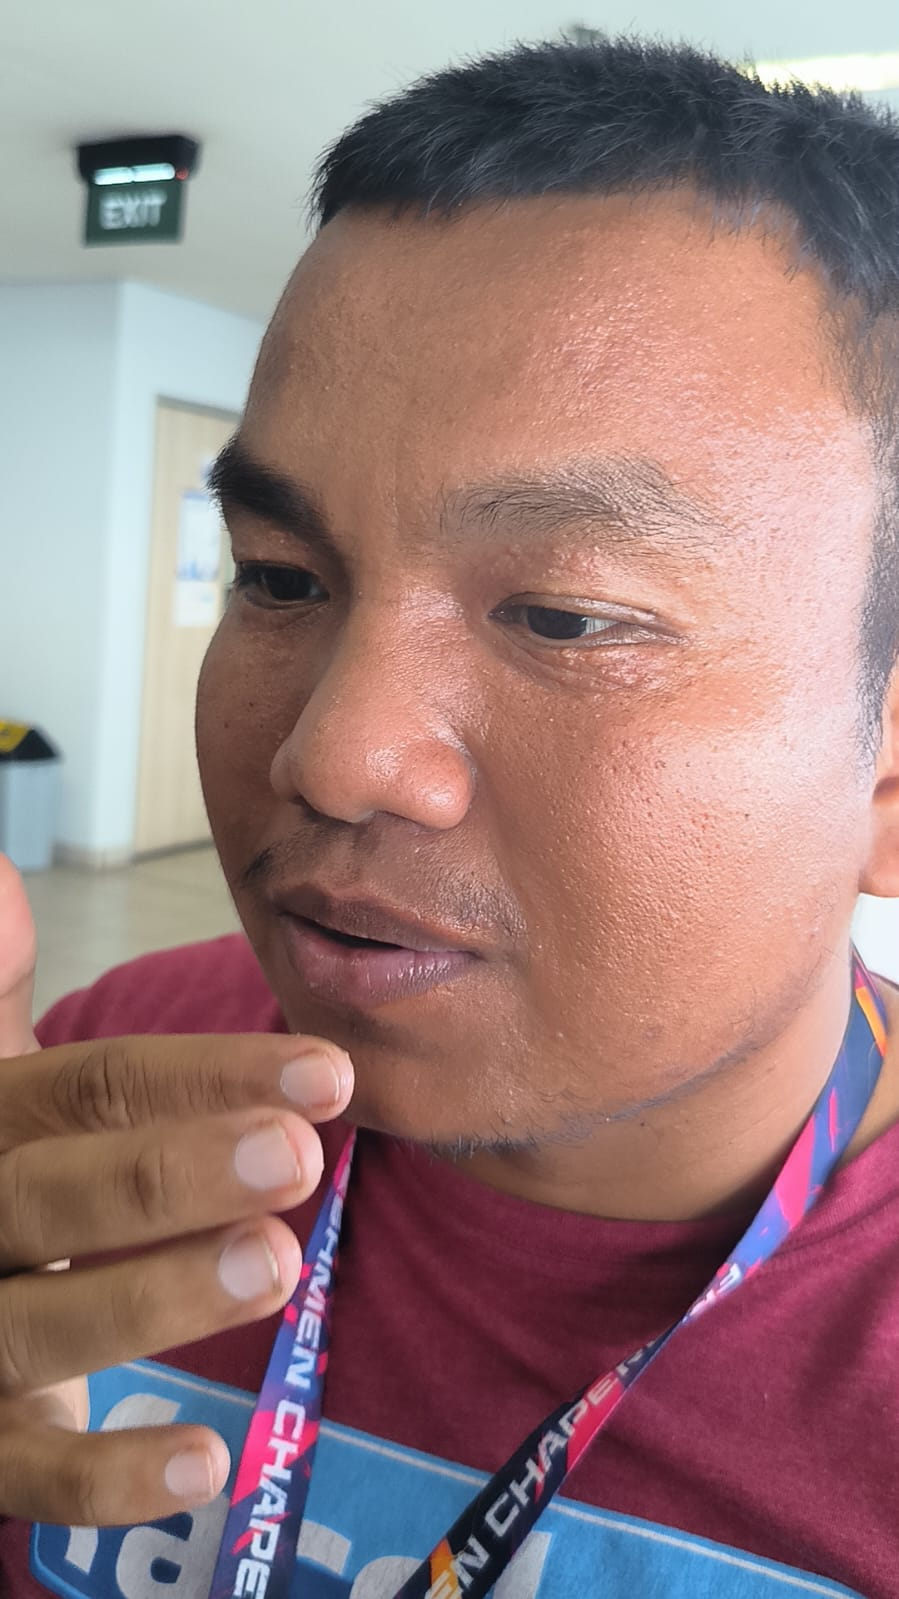

In [100]:
from datasets import load_dataset
ivannn = load_dataset('/kaggle/input/ivannn')
pipe = pipeline('image-classification', model=model_name, device=0)
image = ivannn['train'][0]["image"]
image

In [80]:
pipe(image)


[{'label': 'dry', 'score': 0.5429947376251221},
 {'label': 'oily', 'score': 0.525291383266449},
 {'label': 'normal', 'score': 0.3931202292442322}]

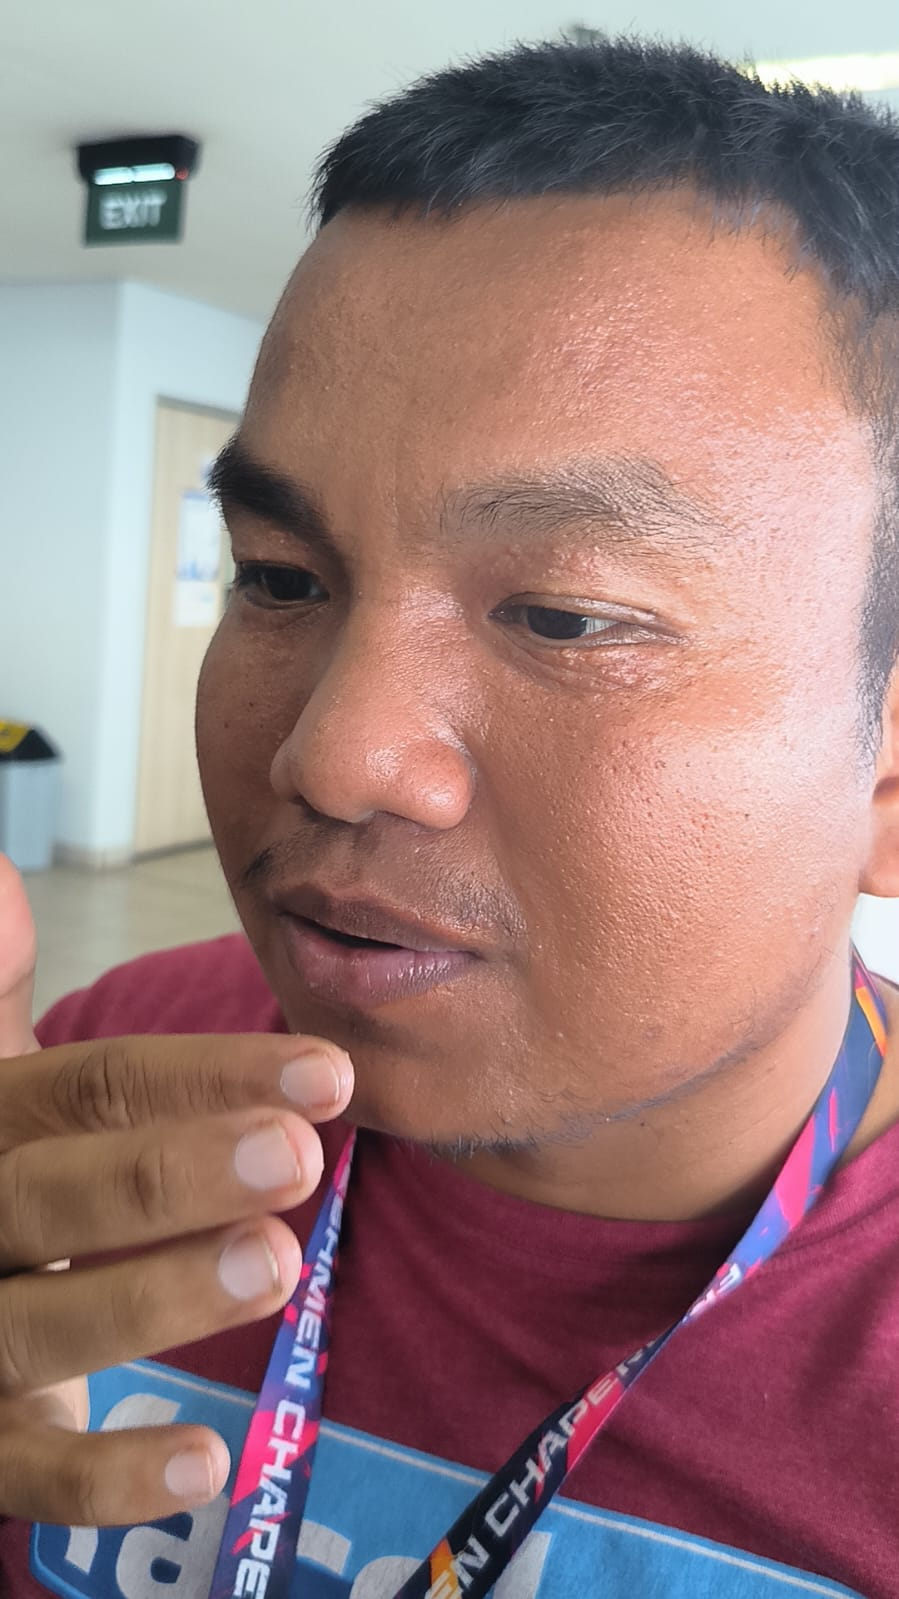

In [104]:
# Accessing the first image from the 'train' split of the 'ivannn' dataset
image = ivannn['train'][0]["image"] 
image

In [113]:
predicted_label = predictions[0]['label']  # The predicted label
confidence_score = predictions[0]['score']  # The confidence score

# Print the predicted label and confidence score
print(f"Predicted Label: {predicted_label}\nConfidence Score: {confidence_score:.2f}")

Predicted Label: dry
Confidence Score: 0.54


In [114]:
pipe(image)

[{'label': 'dry', 'score': 0.5429947376251221},
 {'label': 'oily', 'score': 0.525291383266449},
 {'label': 'normal', 'score': 0.3931202292442322}]